In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
torch.manual_seed(423212)

## Loading MNIST

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
                    batch_size=10, shuffle=False)

Processing...
Done!


## Helper Functions

In [4]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, save=True, name=None, conv=False, simple=False):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data = Variable(data, volatile=True)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save:
        plt.savefig('./plots/' + name + '.png', format='png', dpi=300)
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

In [6]:
input_dim = 784
encoding_dim = 32

model = AutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [7]:
def l1_penalty(var):
    return torch.abs(var).sum()

def train(epoch, sparsity=False, l1_weight=1e-5):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        
        # enforcing sparsity with l1 reg
        if sparsity:
            decoder_out, encoder_out = model(data)
            mse_loss = F.mse_loss(decoder_out, data)
            l1_reg = l1_weight * l1_penalty(encoder_out)
            loss = mse_loss + l1_reg
        else:
            output, _ = model(data)
            loss = F.binary_cross_entropy_with_logits(output, data)
            # loss = F.mse_loss(output, data)
            
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [8]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

/Users/abursuc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.695934
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.320576
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.262557
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.221536
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.214266
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.187220
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.188582
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.182550
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174422
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.172911
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169989
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.157995
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.160938
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.159864
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.147259
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.149106
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.148186
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.145023
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.150311
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.136991
Train Epoch:

KeyboardInterrupt: 

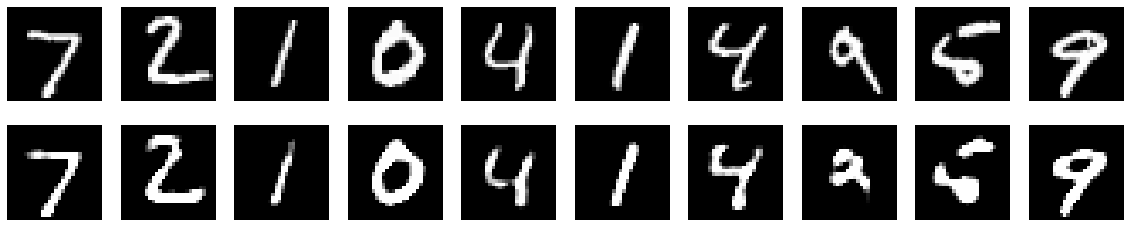

In [13]:
plot_reconstructions(model, save=True, name='simple_bce', simple=True)

## Stacked Auto-Encoder

In [14]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
            # nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [16]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        output = model(data)
        # loss = F.mse_loss(output, data)
        loss = F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [17]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.692739
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.274938
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.265673
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.258315
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.249224
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.234311
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.232333
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.215346
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193257
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.180909
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.193419
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.174861
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.163236
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.164061
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.169866
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.154535
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.157411
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.163265
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.141477
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.156299
Train Epoch:

Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.093700
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.097375
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.094497
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.093871
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.099590
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.098090
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.094356
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.098974
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.100175
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.101503
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.096838
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.097279
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.096479
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.099932
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.095979
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.095215
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.098604
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.096479
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.096312
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0

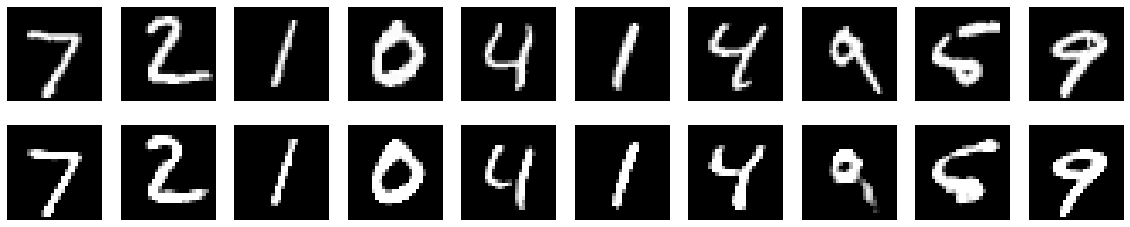

In [18]:
plot_reconstructions(model, save=True, name='stacked_ae_bce', conv=False, simple=False)

## Convolutional Auto-Encoder

In [41]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 2, stride=3, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 2, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=0),
            nn.Tanh(),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [42]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())

In [43]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.mse_loss(output, data)
        loss = F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [44]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.710974
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.529393
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.428230
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.277283
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.255119
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.246950
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.250870
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.241132
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.232416
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.222461
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224473
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.211726
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.209633
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.211617
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.198752
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.196395


KeyboardInterrupt: 

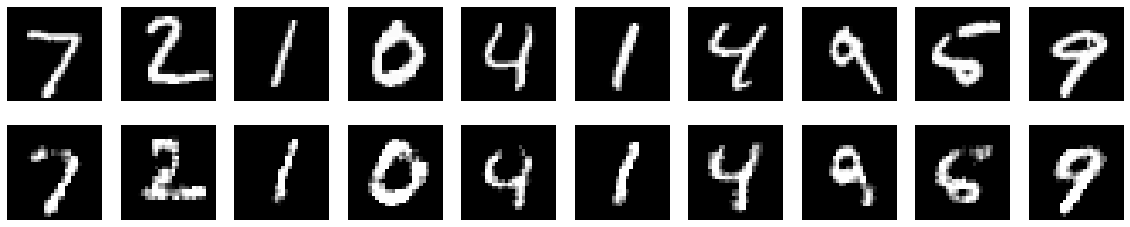

In [40]:
plot_reconstructions(model, save=True, name='conv_ae_bce', conv=True, simple=False)